In [433]:
# Import libraries to be used.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import floor

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.metrics import SCORERS
from sklearn.preprocessing import MinMaxScaler

In [434]:
# Define a random state value
RANDOM_STATE = 3030

In [435]:
# Define column names which will be used instead of the ones in the datasets.
column_names = [
    "age", "sex", "chest_pain_type", "rest_bp", "cholesterol",
    "fasting_bs", "resting_ecg", "max_hr", "exercise_angina", "st_exercise_depression",
    "st_exercise_slope", "major_vessels_fluorospy", "thal", "angiographic_disease"
]
na_values = ["?"] # Define what values will be interpreted as missing values, in this dataset the "?" character is used for this.

# Load all datasets using relative paths and combine into one dataframe.
df = pd.concat([
    pd.read_csv("../data/processed.cleveland.data", names=column_names, na_values=na_values),
    pd.read_csv("../data/processed.hungarian.data", names=column_names, na_values=na_values),
    pd.read_csv("../data/processed.switzerland.data", names=column_names, na_values=na_values),
    pd.read_csv("../data/processed.va.data", names=column_names, na_values=na_values)
]).drop(['st_exercise_slope', 'major_vessels_fluorospy', 'thal'], axis=1)

In [436]:
df[df["angiographic_disease"] > 1] = 1

In [437]:
df['age'].fillna((df['age'].mean()), inplace=True)
df['rest_bp'].fillna((df['rest_bp'].mean()), inplace=True)
df['cholesterol'].fillna((df['cholesterol'].mean()), inplace=True)
df['max_hr'].fillna((df['max_hr'].mean()), inplace=True)
df['st_exercise_depression'].fillna((df['st_exercise_depression'].mean()), inplace=True)
df = df.apply(lambda x:x.fillna(x.value_counts().index[0]))

In [438]:
# Set category attributes
df["sex"] = df["sex"].astype("category")
df["chest_pain_type"] = df["chest_pain_type"].astype("category")
df["fasting_bs"] = df["fasting_bs"].astype("category")
df["resting_ecg"] = df["resting_ecg"].astype("category")
df["exercise_angina"] = df["exercise_angina"].astype("category")
df["angiographic_disease"] = df["angiographic_disease"].astype("category")

In [439]:
df_X = df.drop(["angiographic_disease"], axis=1)

In [440]:
X = MinMaxScaler().fit_transform(df_X.to_numpy())
Y = df["angiographic_disease"].to_numpy()

In [441]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=RANDOM_STATE)

In [442]:
df.isna().sum()

age                       0
sex                       0
chest_pain_type           0
rest_bp                   0
cholesterol               0
fasting_bs                0
resting_ecg               0
max_hr                    0
exercise_angina           0
st_exercise_depression    0
angiographic_disease      0
dtype: int64

In [443]:
svm = SVC()
svm.fit(X=X_train, y=Y_train)

SVC()

In [444]:
sorted(SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we

In [445]:
scores = cross_validate(svm, X, Y, cv=5, scoring=["roc_auc", "f1_macro", "accuracy"])
scores

{'fit_time': array([0.02493477, 0.01495719, 0.01894784, 0.0149579 , 0.01695251]),
 'score_time': array([0.03091741, 0.02394152, 0.03191209, 0.02493358, 0.01795006]),
 'test_roc_auc': array([0.89311702, 0.81850789, 0.95659971, 0.90925395, 0.71006695]),
 'test_f1_macro': array([0.84780811, 0.73801614, 0.83664773, 0.85842803, 0.65982291]),
 'test_accuracy': array([0.84782609, 0.73913043, 0.83695652, 0.85869565, 0.69021739])}

In [446]:
my_results = {}
features = df_X.columns
calculated_scores = []

for i in range(0, 5):
    n_features = 2*(i+1)
    select_k_best = SelectKBest(chi2, k=n_features).fit(X, Y)
    X_new = select_k_best.transform(X)

    index_name = "{}_features".format(n_features)
    my_results[index_name] = {"scores": {}}

    selected_features = select_k_best.get_feature_names_out(input_features=features)
    my_results[index_name]["features"] = selected_features

    print("Running 5-CV with {} features={}".format(n_features, selected_features))
    scores = cross_validate(svm, X_new, Y, cv=5, scoring=["roc_auc", "f1_macro", "accuracy", 'recall', 'precision'])
    for key in scores.keys():
        if ("test_" in key):
            score_name = key.split("test_")[1]
            if (score_name not in calculated_scores):
                calculated_scores.append(score_name)
            my_results[index_name]["scores"][score_name] = scores[key]

Running 5-CV with 2 features=['fasting_bs' 'exercise_angina']
Running 5-CV with 4 features=['rest_bp' 'fasting_bs' 'max_hr' 'exercise_angina']
Running 5-CV with 6 features=['age' 'rest_bp' 'cholesterol' 'fasting_bs' 'max_hr' 'exercise_angina']
Running 5-CV with 8 features=['age' 'sex' 'chest_pain_type' 'rest_bp' 'cholesterol' 'fasting_bs'
 'max_hr' 'exercise_angina']
Running 5-CV with 10 features=['age' 'sex' 'chest_pain_type' 'rest_bp' 'cholesterol' 'fasting_bs'
 'resting_ecg' 'max_hr' 'exercise_angina' 'st_exercise_depression']


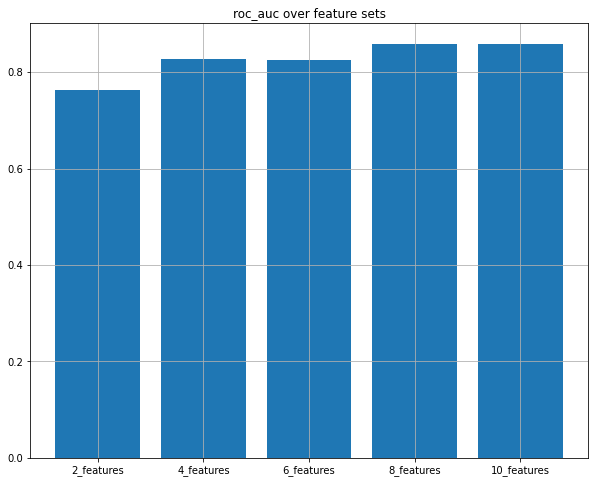

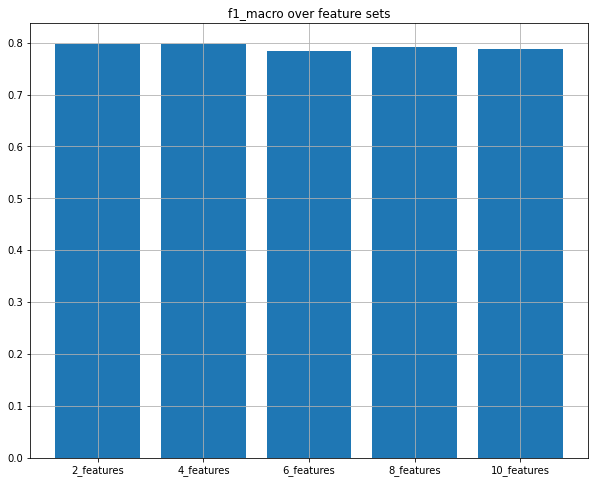

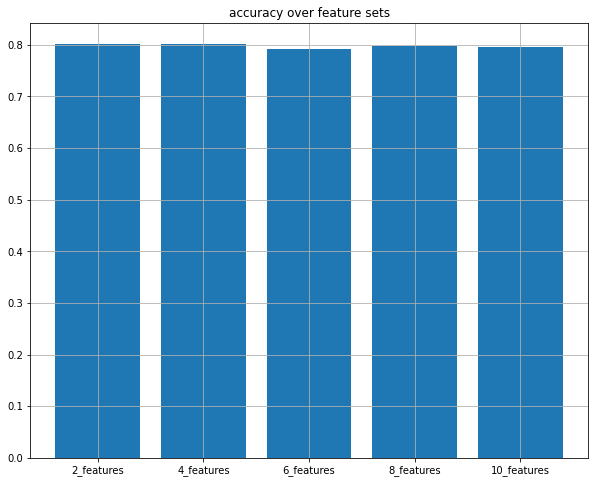

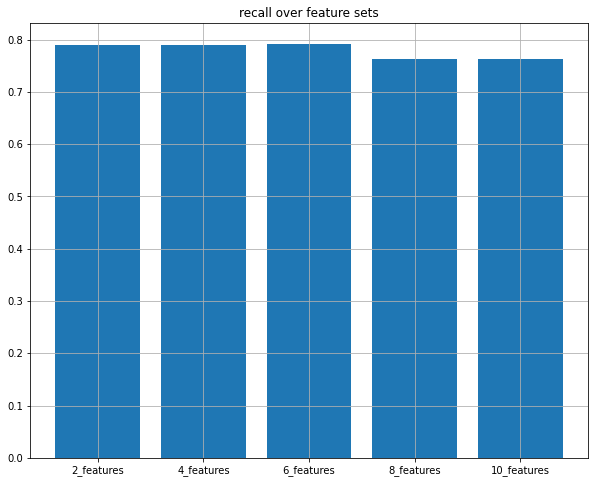

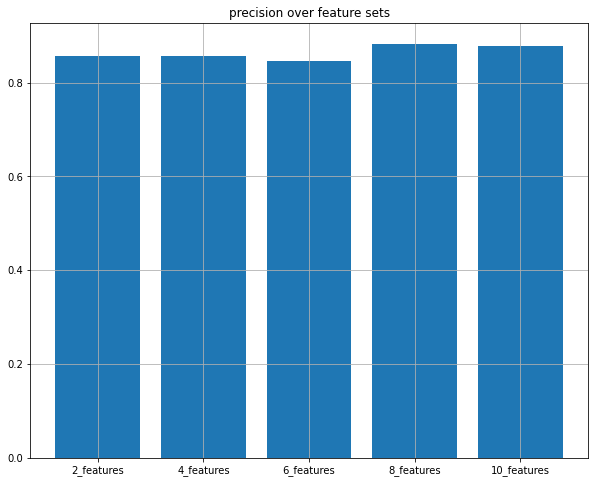

In [447]:
scores_to_plot = {}
for score_name in calculated_scores:
    scores_to_plot[score_name] = {}
    for feat_set in my_results.keys():
        scores_to_plot[score_name][feat_set] = round(np.mean(my_results[feat_set]["scores"][score_name]), 3)
    plt.figure(figsize=(10, 8))
    plt.title("{} over feature sets".format(score_name))
    plt.grid()
    plt.bar(scores_to_plot[score_name].keys(), scores_to_plot[score_name].values())